# Voronoi graph
Research Notebook to create a grid using Voronoi approach.

## Imports

In [47]:
import networkx as nx
nx.__version__

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from bresenham import bresenham
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from planning_utils import heuristic, create_grid
import time

%matplotlib inline

## Load Data

In [48]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [49]:
print('start')
drone_altitude = 30
safety_distance = 3
grid, points, north_offset, east_offset = create_grid(data, drone_altitude, safety_distance)
print('done')

start
done


## Voronoi graph method

In [50]:
print('Creating Voronoi')
# Create a voronoi graph based on location of obstacle centres (2D no height)
t0 = time.time()
np_points = np.array(points)
voronoi_graph = Voronoi(np_points[:,:-1])
print('Voronoi Graph with {0} nodes'.format(len(voronoi_graph.vertices)))
print('Voronoi Graph took {0} seconds to build'.format(time.time()-t0))

Creating Voronoi
Voronoi Graph with 5858 nodes
Voronoi Graph took 0.030017852783203125 seconds to build


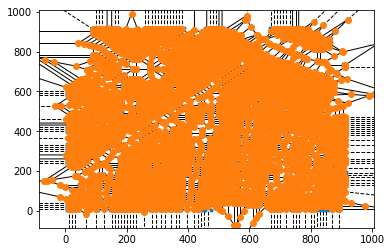

In [51]:
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(voronoi_graph)
plt.show()

In [52]:
import numpy.linalg as LA
from sklearn.neighbors import KDTree

def create_graph_from_voronoi(voronoi_graph):
    g = nx.Graph()
    nodes = tuple(map(tuple, voronoi_graph.vertices))
    tree = KDTree(nodes)
    # Check each edge from graph.ridge_vertices for collision
    k=5
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue

            hit = False
            cells = list(bresenham(int(n1[0]), int(n1[1]), int(n2[0]), int(n2[1])))
            for c in cells:
                # First check if we're off the map
                if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
                    hit = True
                    break
                # Next check if we're in collision
                if grid[c[0], c[1]] > drone_altitude:
                    hit = True
                    break
            # If the edge does not hit on obstacle
            # add it to the list
            if not hit:
                dist = LA.norm(np.array(n2) - np.array(n1))
                g.add_edge((n1[0], n1[1], drone_altitude), (n2[0], n2[1], drone_altitude), weight=dist)

    return g, tree

print('Creating NxGraph')
t0 = time.time()
g, t = create_graph_from_voronoi(voronoi_graph)
print('Graph took {0} seconds to build'.format(time.time()-t0))

Creating NxGraph
Graph took 10.309709072113037 seconds to build


In [53]:
# Getting the largest connected subgraph
g = max(nx.connected_component_subgraphs(g), key=len)

In [54]:
print('Grid dimensions: ', grid.shape)
print('Original nodes: ', len(voronoi_graph.vertices))
print('Graph nodes: %5d' % len(g.nodes))
print('Graph edges: %5d' % len(g.edges))

Grid dimensions:  (921, 921)
Original nodes:  5858
Graph nodes:  3243
Graph edges:  7277


## Save to pickle

In [55]:
import pickle

# Dump the graph with Pickle
pkl_filename = 'graph.voronoi.p'

try:
    with open(pkl_filename, 'wb+') as pfile:
        print('Saving to pickle file ', pkl_filename)
        pickle.dump(
        {
            'graph': g,
            'kdtree': t,
        },
        pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to ', pkl_filename, ':', e)

print('done')

Saving to pickle file  graph.voronoi.p
done


## Load from pickle

In [56]:
import pickle

pkl_filename = 'graph.voronoi.p'
with open(pkl_filename, "rb") as pfile:
    print('Reading pickle')
    dist_pickle = pickle.load(pfile)

    g = dist_pickle['graph']
    t = dist_pickle['kdtree']

print('done')

Reading pickle
done


## Visualize graph

start


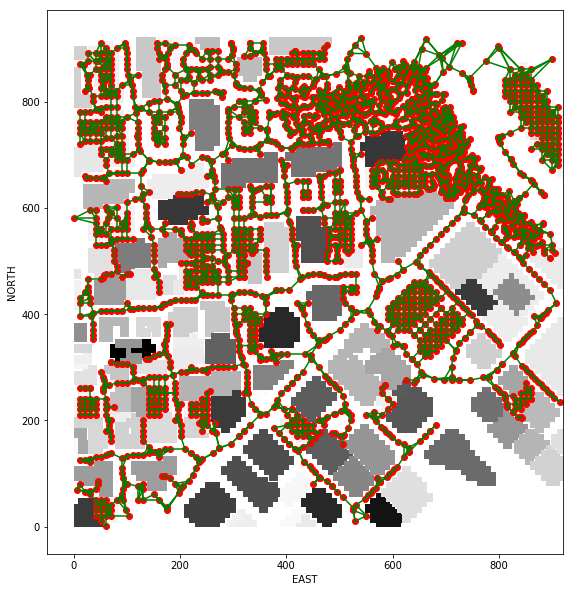

done


In [57]:
import matplotlib.pyplot as plt
print('start')
# Plot it up!
fig = plt.figure(figsize=(10,10))
plt.imshow(grid, origin='lower', cmap='Greys') 

# Draw edges
# and connected nodes in red, not connected in blue
for (n1, n2) in g.edges:
    plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'green', alpha=1)
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1], n1[0], c='red')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
print('done')

## A*

Start:  784
Goal:  2251
Found a path.
52 [(20.7611, 550.7685, 30), (40.76106666663999, 530.76846, 30), (35.76108, 525.76848, 30), (55.7611, 505.76846, 30), (65.7611, 495.76846, 30), (75.7611, 485.76846, 30), (85.76109333333613, 475.76847333332773, 30), (92.52580755190294, 461.9449360640142, 30), (107.903951122449, 447.9113271938788, 30), (121.93757257785308, 432.5331654844294, 30), (142.4277669222235, 422.43512782222155, 30), (155.76109833333277, 405.76846833333275, 30), (165.76109333333613, 395.76847333332773, 30), (175.7611, 385.76846, 30), (190.7611, 400.76846, 30), (200.7611, 410.768465, 30), (210.76111500000496, 400.76846, 30), (220.761115, 395.76846250000125, 30), (238.26113562499987, 383.2684643750001, 30), (250.76113500000002, 390.768465, 30), (260.7611275000037, 400.7684575000037, 30), (270.76113437499623, 410.76845812499795, 30), (290.7611361562489, 430.7684576937493, 30), (315.76114, 445.76846, 30), (323.76114, 445.76846, 30), (342.42783202225417, 459.1018114444672, 30), (35

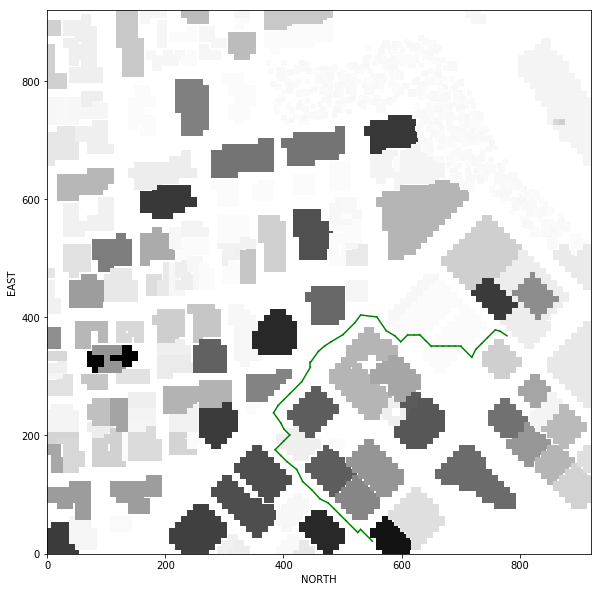

...done


In [60]:
from planning_utils import a_star_graph

rnd = np.random.randint(len(g.nodes))
start = list(g.nodes)[rnd]
print('Start: ', rnd)
rnd = np.random.randint(len(g.nodes))
print('Goal: ', rnd)
goal = list(g.nodes)[rnd]

path, cost = a_star_graph(g, heuristic, start, goal)
print(len(path), path)

print("start")

fig = plt.figure(figsize=(10,10))
plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'green')

plt.xlabel('NORTH')
plt.ylabel('EAST')
plt.show()
print("...done")